# Solar Panel dust detection
## Classify between clean and dusty solar panels using Convolutional Neural Networks
<p align="center">
  <img width="50%" height="50%" src="https://storage.googleapis.com/kaggle-datasets-images/2656907/4551070/3c7b5736ea2b312a7b5606986488ffbd/dataset-cover.jpeg?t=2022-11-20-15-13-55" alt="Example of clean (left) and dirty (right) solar panels"/>
</p>

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Data

This dataset was obtained from Kaggle [solar panel dust detection](https://www.kaggle.com/datasets/hemanthsai7/solar-panel-dust-detection).
It contains images of two classes:
- Clean panels (1493)
- Dusty panels (1069)

## 1.1 Loading data

In [2]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/MCD/solar_panel_dataset.zip"

unzip:  cannot find either /content/drive/MyDrive/Colab Notebooks/MCD/solar_panel_dataset.zip or /content/drive/MyDrive/Colab Notebooks/MCD/solar_panel_dataset.zip.zip.


In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

imgs_dir = "./Detect_solar_dust"
print(os.path.exists(imgs_dir)) # Verify if directory exists

True


In [177]:
from pathlib import Path

# Create clean & dusty folders paths
clean_path = Path(imgs_dir) / "Clean"
dusty_path = Path(imgs_dir) / "Dusty"

# List files in folders
clean_files = os.listdir(clean_path)
dusty_files = os.listdir(dusty_path)

# Count number of images in folders
num_clean = len(clean_files)
num_dusty = len(dusty_files)

# Display counting information
print(f"Found {num_clean} images in clean images folder")
print(f"Found {num_dusty} images in dusty images folder")

Found 1493 images in clean images folder
Found 1069 images in dusty images folder


## 1.2 Exploring data
### 1.2.1 Class balance

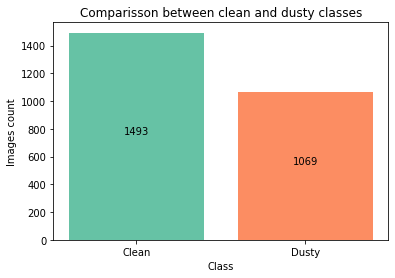

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Labels & numeric values for out plot
labels = ["Clean", "Dusty"]
values = [num_clean, num_dusty]

# Set size and creating a bar plot
plt.figure(figsize=(20,20))
plt.bar(labels, values, color=sns.color_palette('Set2'))

# Put total value in center of each bar
for i in range(len(labels)):
    plt.text(i, (values[i]//2), str(values[i]), ha='center', va='bottom')

# Modify text information
plt.xlabel("Class")
plt.ylabel("Images count")
plt.title("Comparisson between clean and dusty classes")
plt.show()

### 1.2.2 Visualizing example images
Let's visualize some of the images for each class. This will help give us an idea of ​​what our data looks like.

In [8]:
import random

# Define a custom function to create a grid of images, given a path
def plot_random_grid(files_path, title="", rows=3, cols=3):
    files_list = [files_path / file for file in os.listdir(files_path)]
    files_sample = random.sample(files_list, rows*cols)
    files_imgs = [plt.imread(img) for img in files_sample]

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8))
    # Spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.1)

    img_idx = 0
    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(files_imgs[img_idx])
            img_idx += 1

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

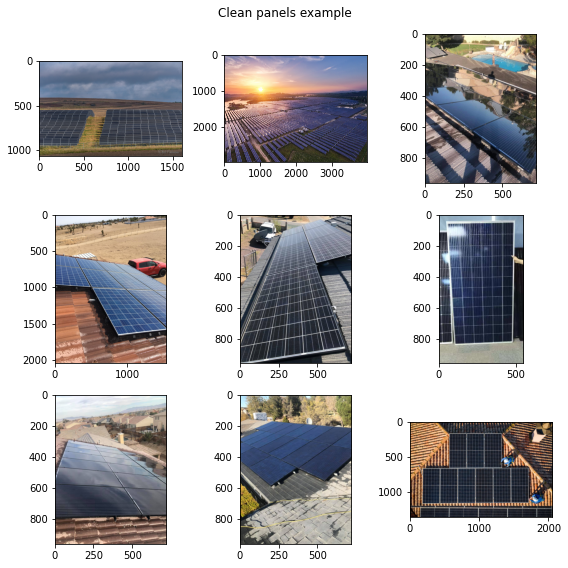

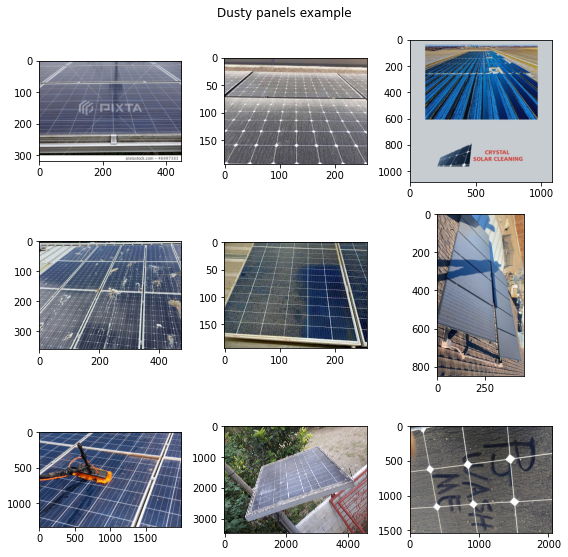

In [9]:
plot_random_grid(clean_path, title="Clean panels example")
print()
plot_random_grid(dusty_path, title="Dusty panels example")

## 1.3 Preparing data loaders
Dataloaders helps us load our images from a folder, this has the advantage of not needing a large amount of RAM to allocate all the images at the same time.  
Keras provides us with a class that makes this task easier `ImageDataGenerator`. You can ee the documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [165]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Scale pixels in [0, 1] range
    validation_split=0.2,  # Split training and validation subsets

    # Data augmentation arguments
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9,1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    zoom_range=0.1,
    fill_mode="constant",
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Scale pixels in [0, 1] range
    validation_split=0.2,  # Split training and validation subsets
    # We don't use data augmentation when validating
)

# Load images from folder
train_generator = train_datagen.flow_from_directory(
    imgs_dir,
    target_size=input_shape,
    batch_size=16,  # We feed batches of 16 images to the model in each iteration
    class_mode='binary',
    subset='training',
    shuffle=True, # Shuffle files so we don't get the images in the same order
)

validation_generator = val_datagen.flow_from_directory(
    imgs_dir,
    target_size=input_shape,
    batch_size=32,
    class_mode='binary',
    subset='validation',
)

Found 2051 images belonging to 2 classes.
Found 511 images belonging to 2 classes.


### 1.3.1 Data Augmentation
Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points. ([Datacamp](https://www.datacamp.com/tutorial/complete-guide-data-augmentation)).  
This will help us reduce overfitting because the network will not always see the same image.

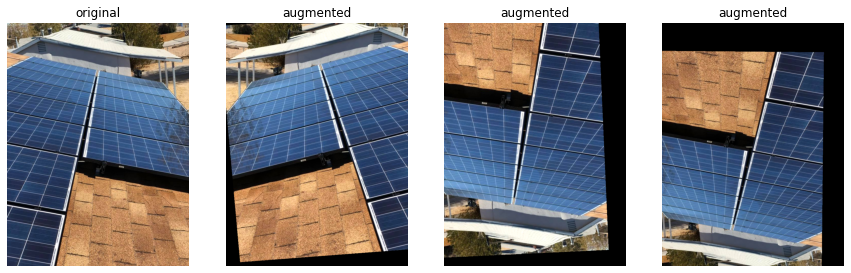

In [166]:
img1 = plt.imread(clean_path/clean_files[1])
aug_iter = train_datagen.flow(np.expand_dims(img1, axis=0), batch_size=1)
normal_iter = val_datagen.flow(np.expand_dims(img1, axis=0), batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
ax[0].imshow(next(normal_iter)[0].astype('float32')); ax[0].axis('off'); ax[0].set_title("original")
for i in range(1, 4):
    image = next(aug_iter)[0].astype('float32')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title("augmented")

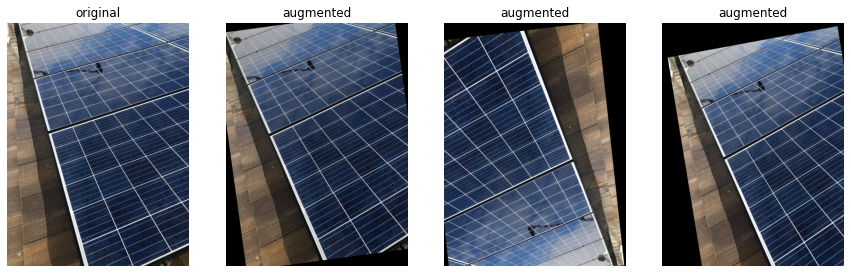

In [167]:
img1 = plt.imread(clean_path/clean_files[3])
aug_iter = train_datagen.flow(np.expand_dims(img1, axis=0), batch_size=1)
normal_iter = val_datagen.flow(np.expand_dims(img1, axis=0), batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
ax[0].imshow(next(normal_iter)[0].astype('float32')); ax[0].axis('off'); ax[0].set_title("original")
for i in range(1, 4):
    image = next(aug_iter)[0].astype('float32')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title("augmented")

# 2. Training

## 2.1 Using pretrained model
Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. ([keras docs](https://keras.io/guides/transfer_learning/)).  
Since our data set is not very large, we can take advantage of a pretrained network, in this case we will use Xception. You can see this network in detail [here](https://paperswithcode.com/method/xception).  


In [203]:
from tensorflow.keras.applications import Xception

pretrained_model = Xception(
        include_top=False,
        input_shape=input_shape+(3,),
        weights="imagenet",
    )

In [169]:
# pretrained_model.trainable = False
for i, layer in enumerate(pretrained_model.layers):
   print(f"Layer index: {i}, layer name: {layer.name}, trainable: {layer.trainable}")

## 2.2 Preparing our model for the data

In [204]:
from tensorflow import keras

inputs = keras.Input(shape=input_shape+(3,))
x = pretrained_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
pretrained_model.trainable = False
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])

In [205]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


## 2.3 Training our model

In [206]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.optimizers import SGD

# early_stopping = EarlyStopping(monitor="val_loss", patience=15, mode="")
best_model_path = f"xception_freeze_lr1e-4_50ep_sig_aug_224.h5"
checkpoint = ModelCheckpoint(filepath=best_model_path,
                            monitor='val_loss',verbose=1,save_best_only=True,mode='min')
# model.compile("SGD", loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

In [289]:
training_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    epochs=50,
    callbacks=[checkpoint]
)

Epoch 1/50
  2/128 [..............................] - ETA: 48s - loss: 0.6396 - binary_accuracy: 0.7188 

C:\Users\Guillermo\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


128/128 [==============================] - ETA: 0s - loss: 0.5605 - binary_accuracy: 0.7194
Epoch 1: val_loss did not improve from 0.55765
128/128 [==============================] - 73s 571ms/step - loss: 0.5605 - binary_accuracy: 0.7194 - val_loss: 0.5617 - val_binary_accuracy: 0.7188
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 0.5631 - binary_accuracy: 0.7248
Epoch 2: val_loss did not improve from 0.55765
128/128 [==============================] - 66s 515ms/step - loss: 0.5631 - binary_accuracy: 0.7248 - val_loss: 0.5645 - val_binary_accuracy: 0.7083
Epoch 3/50
128/128 [==============================] - ETA: 0s - loss: 0.5641 - binary_accuracy: 0.7273
Epoch 3: val_loss did not improve from 0.55765
128/128 [==============================] - 64s 502ms/step - loss: 0.5641 - binary_accuracy: 0.7273 - val_loss: 0.5609 - val_binary_accuracy: 0.7146
Epoch 4/50
128/128 [==============================] - ETA: 0s - loss: 0.5551 - binary_accuracy: 0.7420
Epoch 4: val_l

### 2.3.1 Learning curves
Learning curves help us visualize the main metrics of our network during its training loop.  

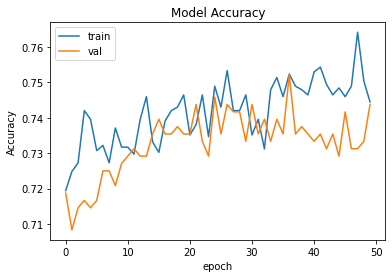

<Figure size 4320x1440 with 0 Axes>

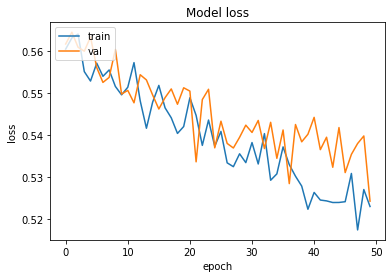

<Figure size 1440x720 with 0 Axes>

In [290]:
# plotting the training accuracy and loss
# Training and validation accuracy:
plt.plot(training_history.history['binary_accuracy'])
plt.plot(training_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.figure(figsize = (60,20))
plt.show()

# Summarize history for loss
plt.plot(training_history.history['loss'],)
plt.plot(training_history.history['val_loss'],)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.figure(figsize = (20,10))
plt.show()

# 3. Testing our model

In [293]:
from tensorflow.keras.models import load_model

# Load our best checkpoint
best_model = load_model(best_model_path)

## 3.1 Making predictions

In [296]:
filepaths, labels = validation_generator.filepaths, validation_generator.labels
print(validation_generator.class_indices)
print(filepaths[:2], labels[:2])
print(filepaths[-2:], labels[-2:])

{'Clean': 0, 'Dusty': 1}
['./Detect_solar_dust\\Clean\\Imgclean_0_0.jpg', './Detect_solar_dust\\Clean\\Imgclean_1000_0.jpg'] [0 0]
['./Detect_solar_dust\\Dusty\\Imgdirty_228_1.jpg', './Detect_solar_dust\\Dusty\\Imgdirty_229_1.jpg'] [1 1]


We can retrieve images paths and corresponding labels from our data generators

### 3.2.1 Inference in validation images
We take our validation images to make inference

In [297]:
y_pred = best_model.predict(validation_generator, validation_generator.n // validation_generator.batch_size)
y_pred = y_pred.squeeze() # Remove extra dimension (batch size)

 6/16 [==========>...................] - ETA: 4s

C:\Users\Guillermo\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 [==============================] - 7s 406ms/step


This is what the model predictions look like, it is a number from 0 to 1 because the sigmoid function is applied to it in the last layer

In [302]:
y_pred[:4]

array([0.62404644, 0.10952732, 0.43372655, 0.5027304 ], dtype=float32)

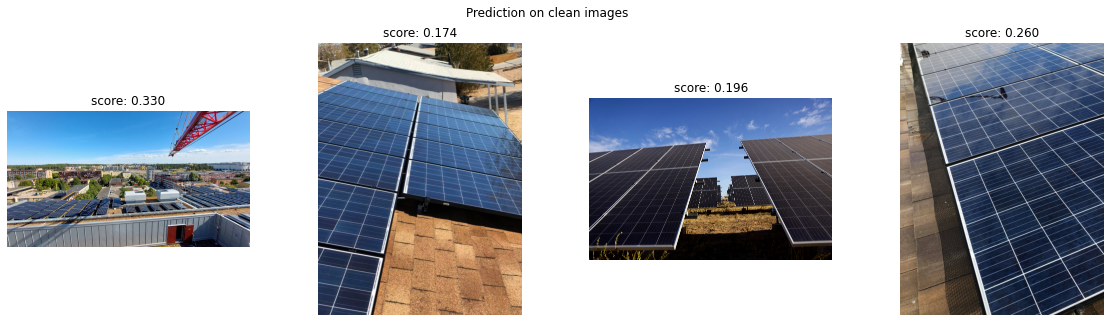

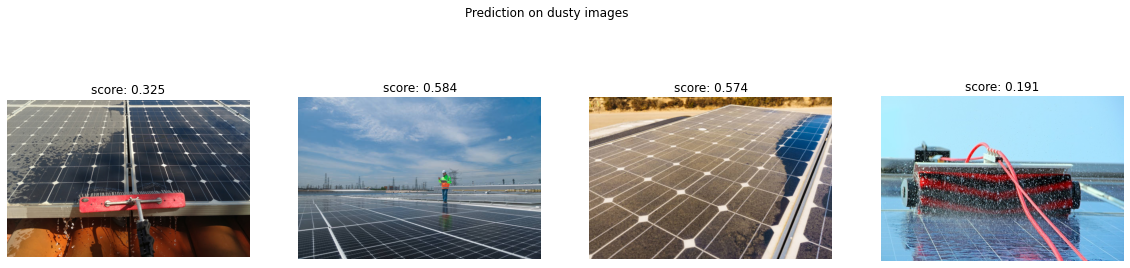

In [299]:
from itertools import compress
from keras.layers import Resizing

resize = Resizing(*input_shape)

clean_sample = list(compress(filepaths, labels == 0))[:4]
dusty_sample = list(compress(filepaths, labels == 1))[:4]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
plt.suptitle("Prediction on clean images")
for i in range(4):
    image = plt.imread(clean_sample[i])
    # print(image.shape)
    im = resize(image)/255.0
    # print(im.shape)
    model_prediction = best_model.predict(np.expand_dims(im, axis=0), verbose=0)
    score = model_prediction.flatten()[0]
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title(f"score: {score:.3f}")
plt.show()
print()
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
plt.suptitle("Prediction on dusty images")
for i in range(4):
    image = plt.imread(dusty_sample[i])
    # print(image.shape)
    im = resize(image)/255.0
    # print(im.shape)
    model_prediction = best_model.predict(np.expand_dims(im, axis=0), verbose=0)
    score = model_prediction.flatten()[0]
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title(f"score: {score:.3f}")
plt.show()

## 3.2 Calculating metrics

### 3.2.1 Loss & Accuracy

In [294]:
model_loss, model_acc = best_model.evaluate(
                            validation_generator,
                            steps=validation_generator.n // validation_generator.batch_size)
print(f"Model loss: {model_loss:.3f}, model accuracy: {model_acc:.3f}")

 6/15 [===========>..................] - ETA: 2s - loss: 0.5579 - binary_accuracy: 0.7135

C:\Users\Guillermo\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 7s 352ms/step - loss: 0.5328 - binary_accuracy: 0.7396
Model loss: 0.533, model accuracy: 0.740


### 3.1.2 Confusion Matrix

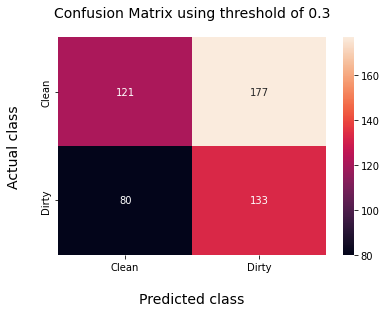

In [295]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

threshold = 0.3
y_preds_thres = np.where(y_pred > threshold, 1, 0)

cf = confusion_matrix(labels, y_preds_thres)

# print(f"Confussion matrix: \n{cf}")

ax = sns.heatmap(cf, annot=True, fmt='d', )
ax.set_xlabel("Predicted class", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Clean', 'Dirty'])
ax.set_ylabel("Actual class", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Clean', 'Dirty'])
ax.set_title(f"Confusion Matrix using threshold of {threshold}", fontsize=14, pad=20)

plt.show()


We choose a threshold below 0.5, since in this case, it may be more convenient for the model to notify us that a panel is dirty even if it is not so sure (False Positive).
A bad case would be for the model to say that a panel is clean when it is not (FN).

![Confusion Matrix](https://miro.medium.com/v2/resize:fit:712/1*Z54JgbS4DUwWSknhDCvNTQ.png)

# 4. Possible improvements
There are some thing we can do to improve our model performance:
- Check data quality
    - Wrong labeled images
    - Pictures clearly show panels
- More data
- Increase image size
    - Images losses quality when resizing
- Hyperparameter tunning
    - Number of layers in top
    - Unfreeze some convolutional layers
    - Learning rate
    - Optimizers (adam, sgd, rmsprop, etc.)
- Different models
    - ResNet
    - VGG
    - MobileNet
    - EfficientNet
- Check the context of the problem
    - When a panel is really dirty?
    - Include dirt levels per score